In [1]:
import pandas as pd
import numpy as np
from matplotlib.cbook import flatten
from osgeo import gdal_array
import gdal
import math
import matplotlib.pyplot as plt

In [2]:
base_path = '/cats/datastore3/claraenv/code/my-projects/'  # '/home/clara/'  # '/cats/datastore3/claraenv/code/my-projects/'  # '/home/clara/Documents/'

# paths

In [3]:
name_image = 'image_1'
image_path = f'{base_path}autoencoders/bare_soil-detection/data/google-earth-engine/{name_image}.tif'
figures_path = f'{base_path}autoencoders/bare_soil-detection/figures/'
out_image_path = f'{base_path}autoencoders/bare_soil-detection/results/image_arrays/{name_image}'

# show original image

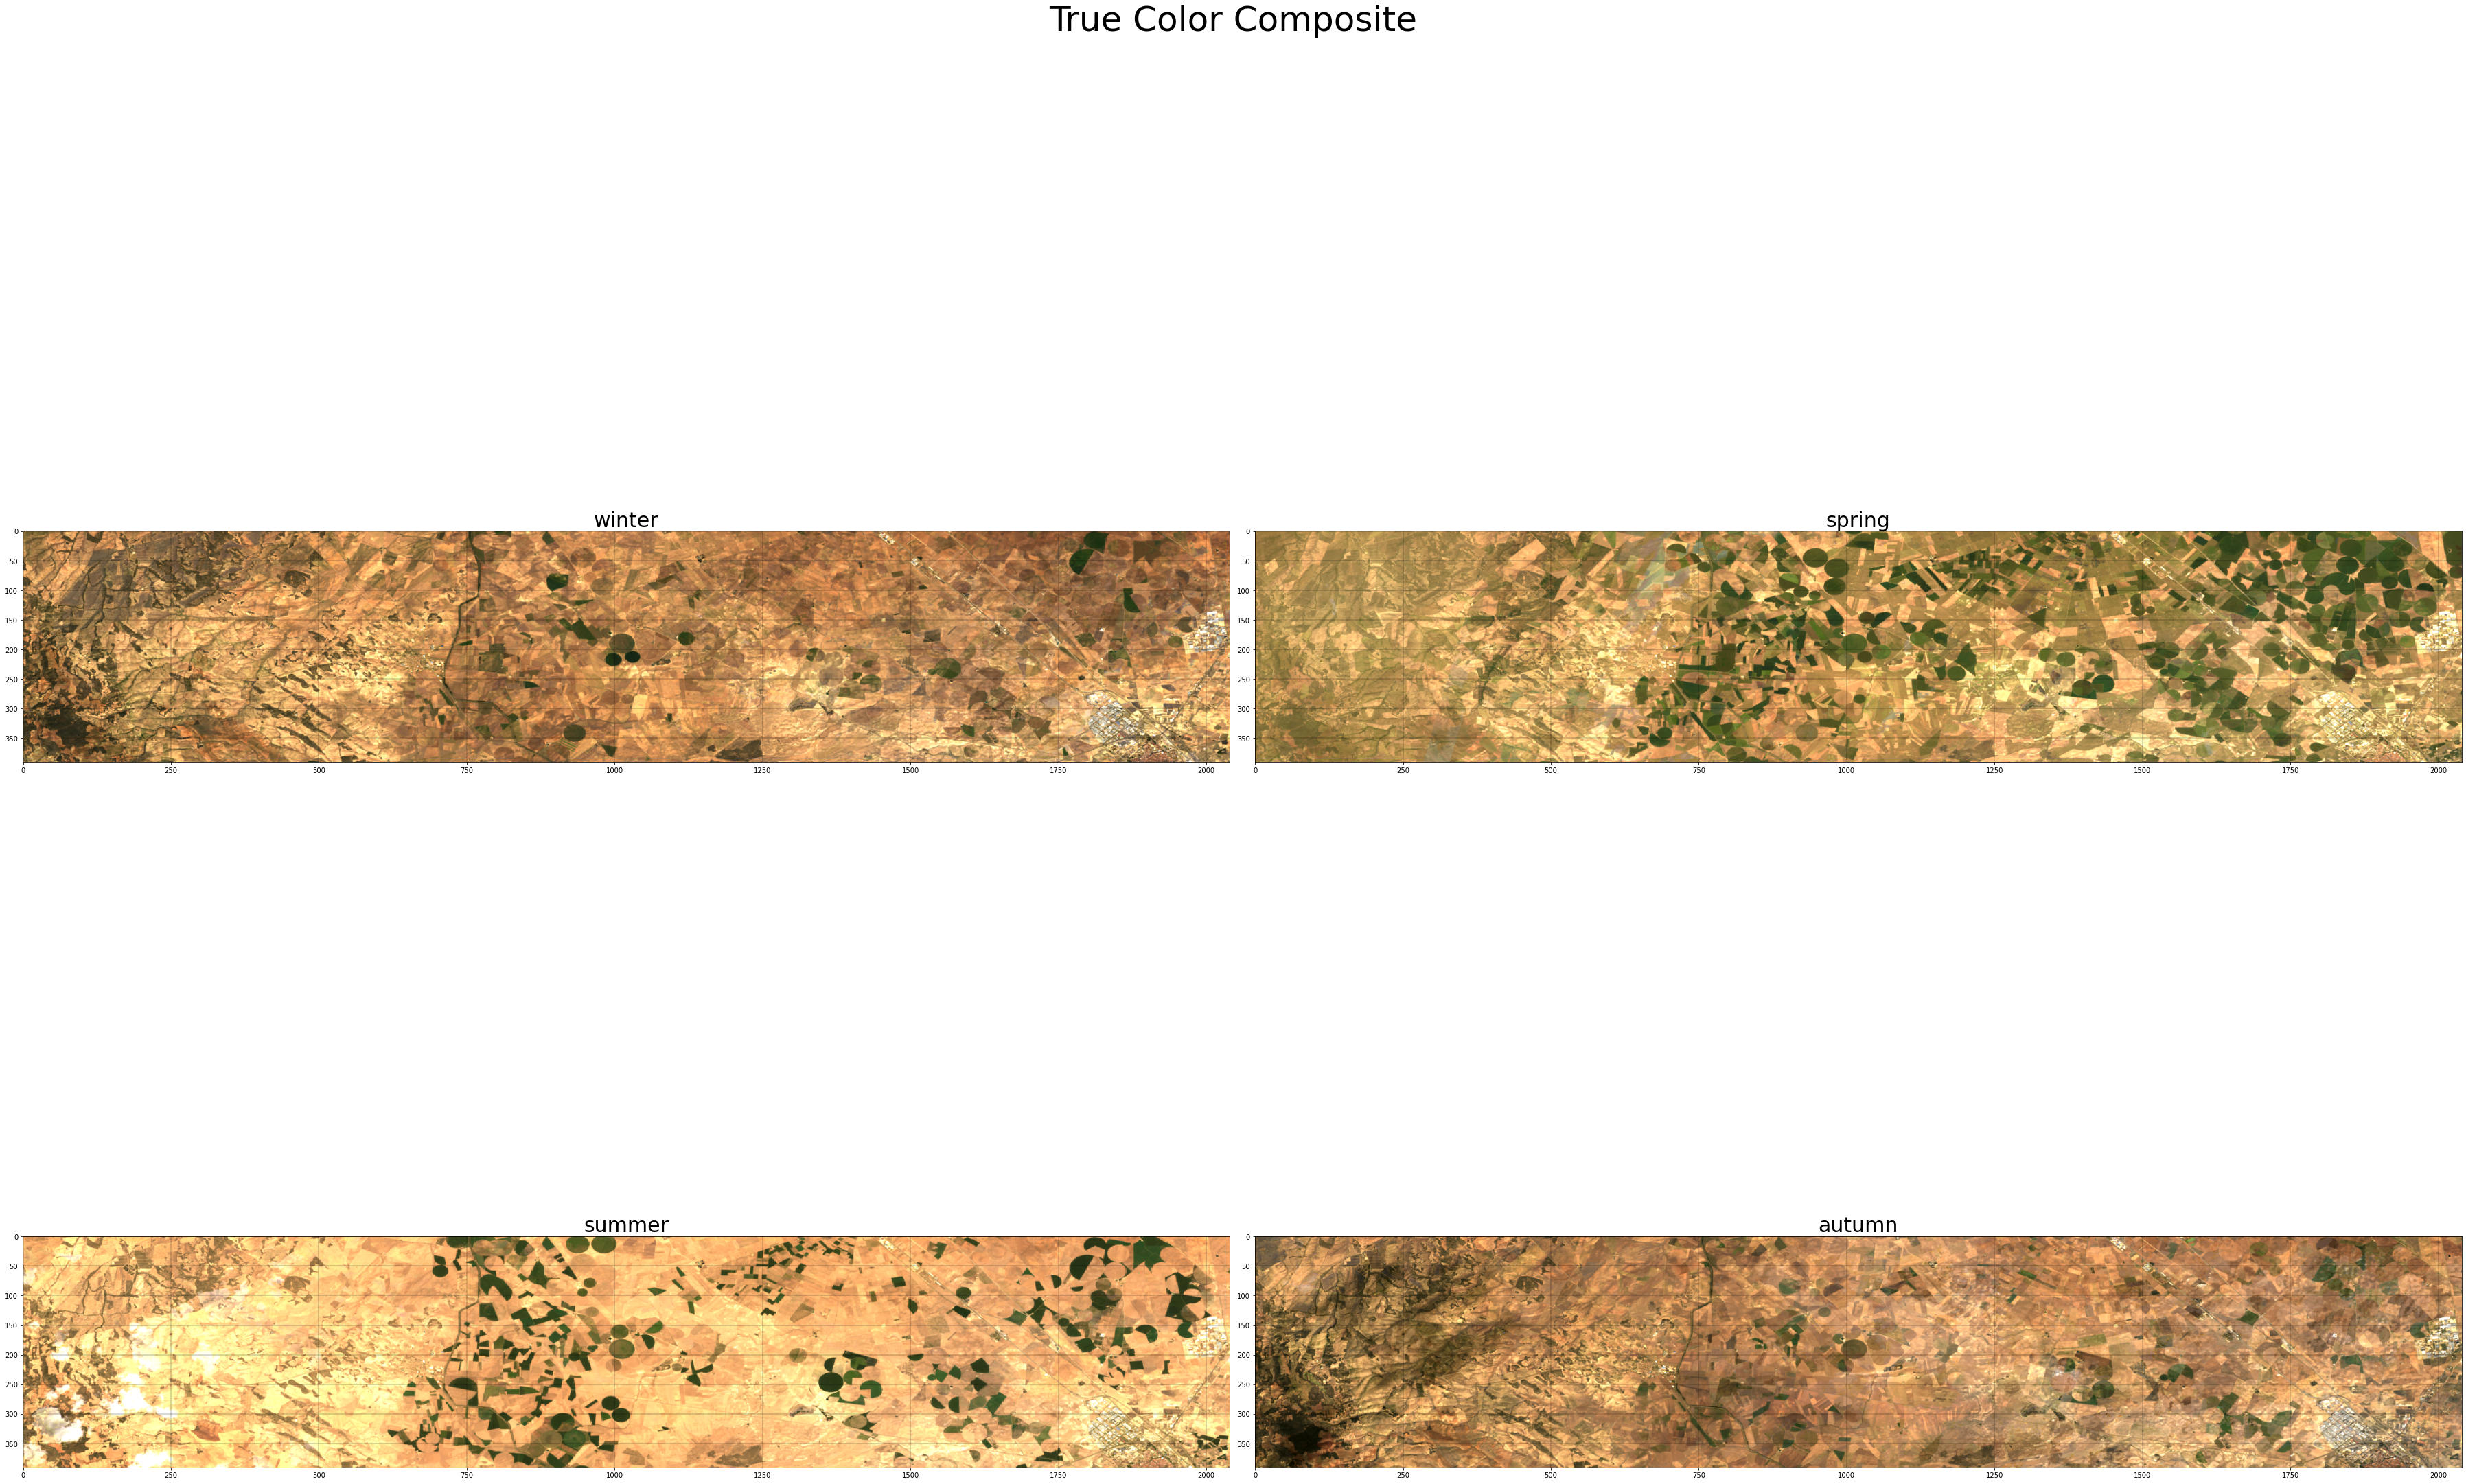

In [4]:
# import image
image = gdal_array.LoadFile(image_path)

# Divide the 4 images for (winter, spring, summer and autumn)
seasons = ['winter', 'spring', 'summer', 'autumn']
image_seasons = np.array(np.split(image, len(seasons)))
image_seasons.shape

# Fill in number of figures:
n_figures = len(seasons)

# Prepare number of columns and rows based on number of figures
n_rows = int(math.ceil((n_figures)**(1/2)))
n_cols = int(math.ceil(n_figures/n_rows))
rows=[]
columns = []
for row in range(n_rows):
    for col in range(n_cols):
        rows.append(row)
        columns.append(col)

# Subplots and figure title
fig, axs = plt.subplots(n_rows, n_cols, figsize= (50,40))
fig.suptitle(f'True Color Composite', fontsize = 50)

# Plot images
for sp in range(n_figures):
    image_season = image_seasons[sp]
    img = np.dstack((image_season[3, ...]/2500, image_season[2, ...]/2500, image_season[1, ...]/2500))
    img = np.clip(img, 0, 1)
    ax = axs[rows[sp], columns[sp]]
    img = ax.imshow(np.array(img))
    ax.grid(color='black', linewidth=0.3)
    ax.set_title(f'{seasons[sp]}', fontsize=30)

# delete empty figures
for image in range(n_figures, n_rows*n_cols):
    axs[rows[image], columns[image]].set_axis_off()

# save
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig(f'{figures_path}/original_TCC.png', format='png', dpi=50)
plt.show()

# reshape: temporal samples x bands

The original image from GEE is a stack of bands x 4 different dates (one per season). It should be reshaped to (rows x columns x temporal images) x bands.

In [5]:
# import image
image = gdal_array.LoadFile(image_path)
print('image shape (bands x seasons, rows, columns):', image.shape)

# join columns and rows
image_reshape = image.reshape(image.shape[0], image.shape[1]*image.shape[2])
print('image reshaped (bands x seasons, rows x columns):', image_reshape.shape)

# split the 4 seasons
image_split = np.array(np.split(image_reshape, indices_or_sections=4, axis = 0))
print('image splitted (seasons, bands, rows x columns):', image_split.shape)

# add date
date = np.array([[1]*image_reshape.shape[1], [2]*image_reshape.shape[1], [3]*image_reshape.shape[1], [4]*image_reshape.shape[1]])
date = np.expand_dims(date, axis=1)
image_date = np.concatenate([image_split, date], axis=1)
print('image and date (seasons, bands, rows x columns):', image_date.shape)

# concatenate arrays along axis 0 --> along axis 2
winter = image_date[0]
spring = image_date[1]
summer = image_date[2]
autumn = image_date[3]
image_concatenated = np.concatenate([winter, spring, summer, autumn], axis = 1)
print('image concatenated (bands, rows x columns x seasons):', image_concatenated.shape)

# transpose axis to pixels x bands
image_transpose = np.transpose(image_concatenated)
print('image transposed (rows x columns x seasons, bands):', image_transpose.shape)

image shape (bands x seasons, rows, columns): (28, 391, 2040)
image reshaped (bands x seasons, rows x columns): (28, 797640)
image splitted (seasons, bands, rows x columns): (4, 7, 797640)
image and date (seasons, bands, rows x columns): (4, 8, 797640)
image concatenated (bands, rows x columns x seasons): (8, 3190560)
image transposed (rows x columns x seasons, bands): (3190560, 8)


# add features

In [6]:
# features

# save data

**WARNING:** arrays saved in numpy have a file size greater than 100 MB. that's why I delete them before commit.

In [7]:
# output array
out_image = image_transpose

# save
np.save(out_image_path, out_image)

# End